In [1]:
# Assignment 1

In [2]:
import sys
import re
import statistics
import nltk
import math
import itertools
import scipy.stats
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline

## Daten einlesen

In [3]:
people_en = pd.read_csv('people_wiki_EN.csv', sep=',')
people_de = pd.read_csv('10k-people-raw.csv', sep=';')

## Hilfsfunktionen

In [4]:
def box_plot(dist, title = None):
    chars = [chr(c) for c in range(ord('a'), ord('z') + 1)]
    
    fig1, ax1 = plt.subplots(figsize = (18, 8))
    ax1.set_xlabel('Character')
    ax1.set_ylabel('Frequency')
    ax1.boxplot(dist, labels = chars)
    ax1.set_ylim([0, 0.3])
    if title is not None:
        plt.title(title)
    plt.show()

In [5]:
def frequency_plot(mean_en, mean_de):
    chars = [chr(c) for c in range(ord('a'), ord('z')+1)]
    ind = np.arange(len(chars))
    width = 1
    frequency = np.log((np.array(mean_en) / np.array(mean_de)))
    color = ['g' if f > 0 else 'b' for f in frequency]
    
    fig, ax = plt.subplots(figsize = (18, 8))
    rects1 = ax.bar(ind, frequency, width, color = color, edgecolor = 'black')
    ax.set_xticklabels(chars)
    ax.set_xticks(ind + (width * 0.5) - 0.5)
    ax.set_xlabel('Character')
    ax.set_ylim([-2, 2])
    ax.set_ylabel('F')
    ax.set_xlim([-0.5, len(chars) - 0.5])
    ax.text(1, 1.5, 'More frequent in English ', bbox={'facecolor':'green', 'alpha':0.5, 'pad':10})
    ax.text(1, 1.2, 'More frequent in German', bbox={'facecolor':'blue', 'alpha':0.5, 'pad':10})
    ax.text(5.5, 1.35, r'$F = \ln(\frac{mean_e}{mean_d})$', fontsize=25)
    plt.show()

In [6]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Greens):
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm[np.isnan(cm_norm)] = 0
    cm_norm = np.around(cm_norm, decimals = 3)
        
    plt.imshow(cm_norm, interpolation='nearest', cmap = cmap)
    
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Häufigkeitsverteilungen

In [7]:
def character_distribution(people):
    # Implementieren Sie eine Funktion die die Buchstabenhäufigkeiten berechnet.
    # Die Funktion soll folgendes zurückgeben:
    #  mean: Durchschnittlicher relative Häufigkeit pro Buchstabe 
    #  std: Relative Standardabweichung pro Buchstabe
    #  dist: Relative Häufigkeit pro Text und pro Buchstabe 
    mean = np.ones(shape = 26)
    std = np.ones(shape = 26)
    dist = np.ones(shape = (len(people), 26))
    hist = np.ones(shape = (26,len(people)))
    
    N = len(people)
    letters = 'abcdefghijklmnopqrstuvwxyz'
    for i in range(N):
        lenPeople = len(re.sub(r"[^a-z]+",'',people[i]))
        if (lenPeople > 0):
            fdist = nltk.FreqDist(char.lower() for char in people[i] if char in letters)
            for idx, letter in enumerate(letters):
                percent = np.divide(fdist[letter],lenPeople)
                dist[i,idx] = percent
                hist[idx,i] = percent
    for idx, letter in enumerate(letters):
        mean[idx] = np.mean(hist[idx])
        std[idx] = np.std(hist[idx])          
    
    return mean, std, dist

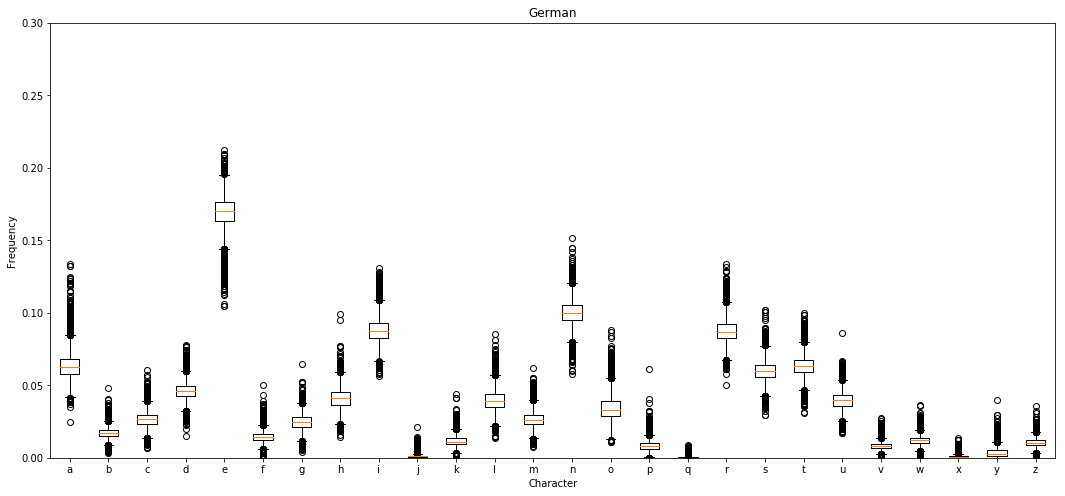

In [8]:
mean_de, std_de, dist_de = character_distribution(people_de['text'])
box_plot(dist_de, 'German')

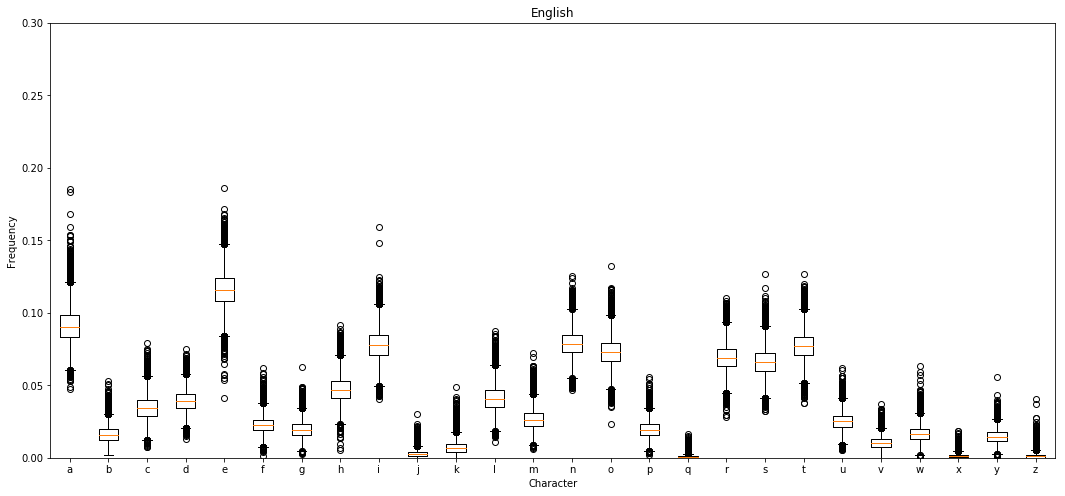

In [9]:
mean_en, std_en, dist_en = character_distribution(people_en['text'])
box_plot(dist_en, 'English')

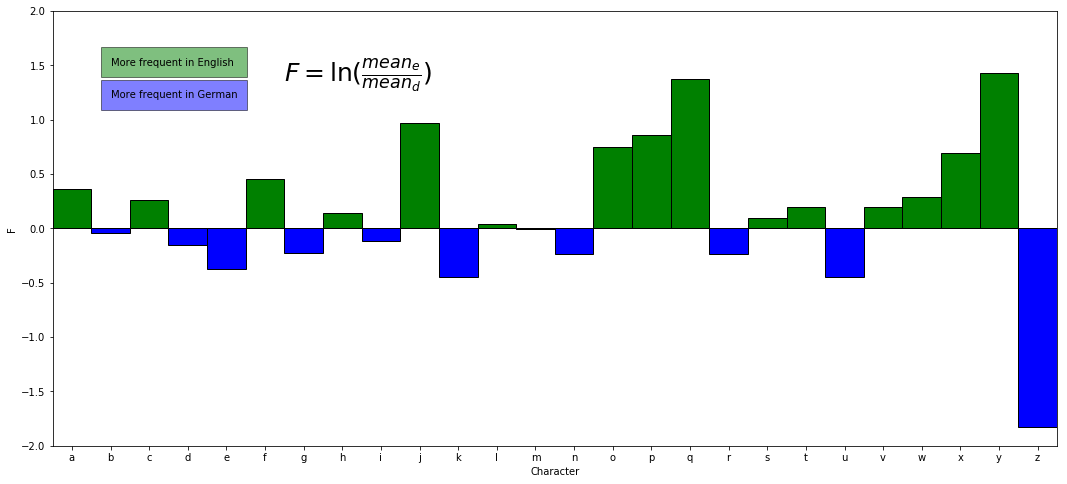

In [10]:
frequency_plot(mean_en, mean_de)

## Spracherkennung

In [11]:
def determine_language(mean_de,mean_en,texts):
    lang = []
    N = len(texts)
    for i in range(N):
        errorGerman = 0
        errorEnglish = 0
        errorOther = 0.25
        mean_text = np.ones(shape = 26)
        letters = 'abcdefghijklmnopqrstuvwxyz'
        lenText = len(re.sub(r"[^a-z]+",'',texts[i]))
        if(lenText>0):
            fdist = nltk.FreqDist(char.lower() for char in texts[i] if char in letters)
            for idx, letter in enumerate(letters):
                percent = np.divide(fdist[letter],lenText)
                mean_text[idx] = percent
        
        for j,letter in enumerate(mean_de):
            errorEnglish += abs(mean_text[j]-(mean_en[j]))
            errorGerman += abs(mean_text[j]-(mean_de[j]))
        #decision tree
        if errorGerman < errorEnglish and errorGerman < errorOther:
            lang.append('G')
        elif errorEnglish < errorGerman and errorEnglish < errorOther:
            lang.append('E')
        else:
            lang.append('X')
    return lang

In [12]:
def accuracy(cm):
    i = np.eye(cm.shape[0])
    return (i * cm).sum() / cm.sum()

In [13]:
people_test = pd.read_csv('Language_test.csv', sep=';', quotechar='|')
lang_true = np.array(people_test['language'])

In [14]:
lang = determine_language(mean_de,mean_en,people_test['text'])
cm = confusion_matrix(lang_true, lang)
print('Accuracy:', accuracy(cm))

Accuracy: 1.0


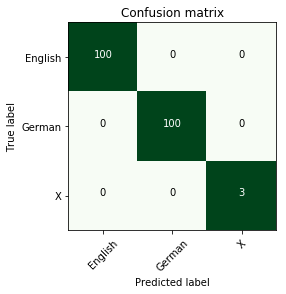

In [15]:
plot_confusion_matrix(cm, ['English', 'German', 'X'])